### Option Pricing using Monte Carlo method and AR(1) with stochastic drift

Assuming stock price is at time $t$:

$ S_t = \beta_0 + \beta_1 t + \beta_2 S_{t-1} + u_t $

where $u_t$ ~ $N(0, \sigma_u^2)$, and drift term $\beta_0$ ~ $N(\hat{\beta_0}, \sigma_{\hat{\beta_0}}^2) $


In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
import datetime as dt
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm


In [87]:
stock = "Equinor"
ticker = "EQNR.OL"
today = dt.datetime.today()

df = yf.download(ticker, start='2023-01-01', end=today, period='1d')
df.reset_index(inplace=True)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
483,2024-12-02,266.100006,271.049988,266.100006,268.100006,268.100006,2471272
484,2024-12-03,268.899994,273.399994,268.799988,271.250000,271.250000,2358504
485,2024-12-04,273.000000,274.450012,267.000000,267.100006,267.100006,2374222
486,2024-12-05,268.750000,269.100006,264.399994,265.100006,265.100006,2743828
487,2024-12-06,265.950012,268.250000,260.200012,260.200012,260.200012,2445691


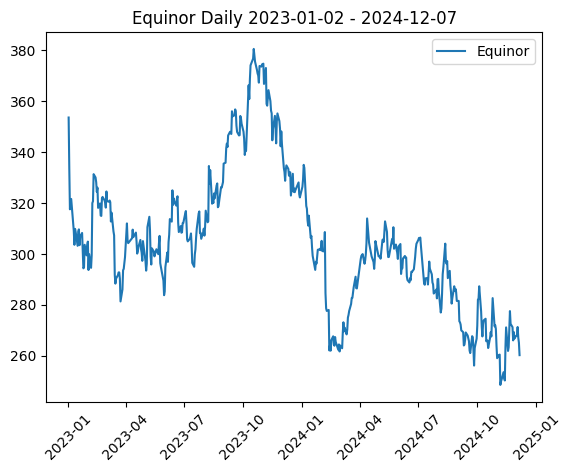

In [88]:
plt.plot(df['Date'], df['Close'], label=stock)
plt.legend()
plt.xticks(rotation=45)
plt.title(f'{stock} Daily {df.loc[0, "Date"].date()} - {today.date()}')
plt.show()

In [113]:
t = [i+1 for i in range(len(df)-1)]
S = np.array(df['Close'])
S_lag = S[0:-1]
S = S[1:]
vol = np.sqrt(np.var(S))

X = pd.DataFrame({'Time': t, 'S_lag': S_lag})
X = sm.add_constant(X)

S_m = sm.OLS(S, X).fit()

coefs = S_m.params
sde = S_m.bse
ser = np.sqrt(S_m.mse_resid)
R2 = S_m.rsquared

S_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     6918.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:50:40   Log-Likelihood:                -1490.0
No. Observations:                 487   AIC:                             2986.
Df Residuals:                     484   BIC:                             2999.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5421      3.244      2.325      0.020       1.168      13.917
Time          -0.0023      0.002     -1.185      0.237      -0.006       0.002
S_lag          0.9765      0.010    100.335      0.000       0.957       0.996
==============================================================================
Omnibus:                       33.621   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.621
Skew:                          -0.106   Prob(JB):                     5.27e-28
Kurtosis:                       5.479   Cond. No.                     5.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Drift analysis


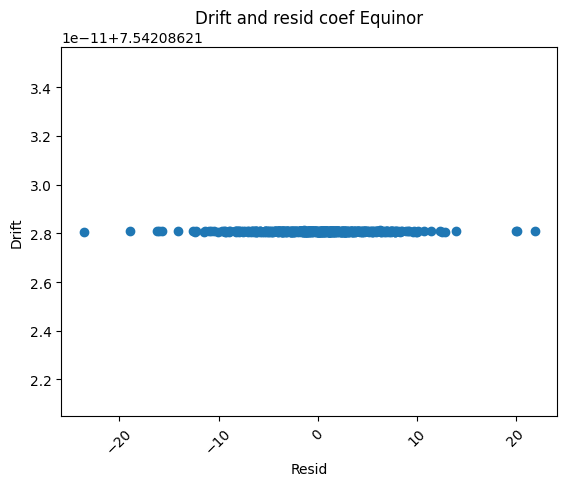

,Drift,Resid
Drift,1.00000,0.01272
Resid,0.01272,1.00000


In [90]:
drift_t = [S[i] - t[i]*coefs['Time'] - S_lag[i]*coefs['S_lag'] - np.array(S_m.resid)[i] for i in range(len(S))]
resid_t = S_m.resid
drift_resid = pd.DataFrame({"Drift": drift_t, "Resid": resid_t})

plt.scatter(resid_t, drift_t, label=f"Drift and Residual terms {stock}")
plt.xticks(rotation=45)
plt.xlabel("Resid")
plt.ylabel("Drift")
plt.title(f"Drift and resid coef {stock}")
plt.show()
drift_resid.corr()

### Model for Random Walk with stochastic drift

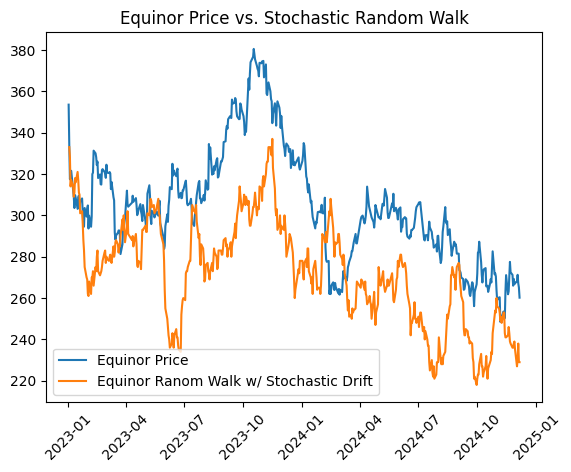

(25.68899013933355, 28.058629109117376)

In [100]:
N = len(S)

S_t = np.repeat(0, N)
S_t[0] = S[0]
for j in range(N-1):
    drift = np.random.normal(coefs['const'], 0.5*sde['const'])
    u = ser*np.random.normal()
    L = np.linalg.cholesky(drift_resid.corr())
    d_t, u_t = np.inner(L, np.array([drift, u]))
    S_t[j+1] = d_t + j*coefs['Time'] + S_t[j]*coefs['S_lag'] + u_t

plt.plot(df['Date'], df['Close'], label = f"{stock} Price")
plt.plot(df['Date'][1:], S_t, label = f"{stock} Ranom Walk w/ Stochastic Drift")
plt.xticks(rotation=45)
plt.legend()
plt.title(f"{stock} Price vs. Stochastic Random Walk")
plt.show()

(np.sqrt(np.var(S_t)), vol)

### Monte Carlo Model

Call Option Price of Equinor w/ Strike @ 261.16: NOK 6.65 +- 0.32
Put Option Price of Equinor w/ Strike @ 261.16: NOK 8.08 +- 0.36


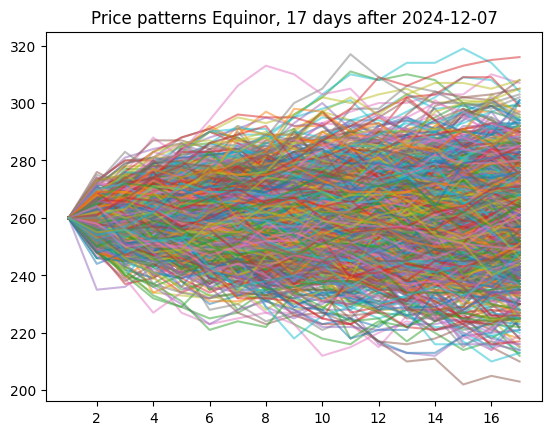

In [ ]:
K = 261.16
T = 17
M = 1000
r = 0.045
y = T/365

paths = []
Cs = []
Ps = []

for i in range(M):
    S_t = np.repeat(0, T)
    S_t[0] = S[-1]
    for j in range(T-1):
        drift = np.random.normal(coefs['const'], 0.5*sde['const'])
        u = ser*np.random.normal()
        L = np.linalg.cholesky(drift_resid.corr())
        dift, u_t = np.dot(L, np.array([drift, u]))
        S_t[j+1] = drift + (j+N)*coefs['Time'] + S_t[j]*coefs['S_lag'] + u_t

    Ct = max(0, S_t[-1] - K)
    C0 = np.exp(-r*y)*Ct
    Cs.append(C0)

    Pt = max(0, K - S_t[-1])
    P0 = np.exp(-r*y)*Pt
    Ps.append(P0)
    paths.append(S_t)
    plt.plot(range(1, T+1), S_t, alpha=0.5)

C0 = round(np.mean(Cs), 2)
sde_c = round(np.sqrt(np.var(Cs))/np.sqrt(M), 2)
P0 = round(np.mean(Ps), 2)
sde_p = round(np.sqrt(np.var(Ps))/np.sqrt(M), 2)

print(f"Call Option Price of {stock} w/ Strike @ {K}: NOK {C0} +- {sde_c}")
print(f"Put Option Price of {stock} w/ Strike @ {K}: NOK {P0} +- {sde_p}")
plt.title(f"Price patterns {stock}, {T} days after {today.date()}")
plt.show()

### Value at Risk

95% confidence interval: [-13.49%, 13.47%]


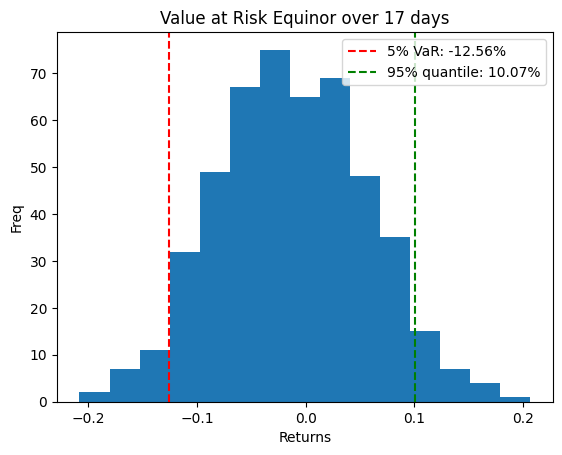

In [123]:
returns = [paths[i][-1] / S[-1] -1 for i in range(N)]
mu_r = np.mean(returns)
sd_r = np.sqrt(np.var(returns))
_5q = stats.norm.isf(0.95, mu_r, sd_r)
_95q = stats.norm.isf(0.05, mu_r, sd_r)


plt.hist(returns, 15)
plt.axvline(_5q, color="red", linestyle="--", label=f"5% VaR: {round(_5q*100, 2)}%")
plt.axvline(_95q, color="green", linestyle="--", label=f"95% quantile: {round(_95q*100, 2)}%")
plt.xlabel("Returns")
plt.ylabel("Freq")
plt.legend()
plt.title(f"Value at Risk {stock} over {T} days")
print(f"95% confidence interval: [{round(mu_r-1.96*sd_r*100, 2)}%, {round(mu_r+1.96*sd_r*100, 2)}%]")
plt.show()